# Road Pathfinder with Capacity Contraints

In [11]:
import os
import sys
import json
default = {'scenario': 'base', 'training_folder': '../..'} # Default execution parameters
manual, argv = (True, default) if 'ipykernel' in sys.argv[0] else (False, dict(default, **json.loads(sys.argv[1])))

sys.path.insert(0, r'../../../quetzal') # Add path to quetzal
from quetzal.model import stepmodel

## Road Model

In [12]:
sm = stepmodel.read_zippedpickles(argv['training_folder'] + '/model/{scen}/aon_pathfinder'.format(scen=argv['scenario']))

distribution = stepmodel.read_zippedpickles(argv['training_folder'] + '/model/{scen}/distribution'.format(scen=argv['scenario']))
sm.volumes = distribution.volumes

epsg: 100%|██████████| 3/3 [00:00<00:00, 1315.65it/s]


In [13]:
# Each link can have its own capacity
sm.road_links['capacity'] = 2000

# Keep relevant OD
v = sm.volumes.set_index(['origin', 'destination'])["car_owner"]
od_set = set(v.loc[v>1].index)

# Iterative Road Patfinder

In [14]:
constrained = sm.copy()
free = sm.copy()

constrained.step_road_pathfinder(method='BFW',
                             tolerance=0.01,
                             maxiters=50,
                             od_set=od_set,
                             volume_column='car_owner',
                             log=True,
                             num_cores=1,
                             access_time='time',
                             path_analysis=False)

vdf not found in road_links columns. Values set to 'default_bpr'
alpha not found in road_links columns. Values set to 0.15
beta not found in road_links columns. Values set to 4
limit not found in road_links columns. Values set to 20
penalty not found in road_links columns. Values set to 0
iteration | Phi |  Rel Gap (%)
0 0.1688 51.347
1 0.1547 27.815
2 0.1359 13.088
3 0.1266 6.272
4 0.1391 3.573
5 0.1734 1.963
6 0.4484 1.514
7 0.8 0.691
8 0.8 0.126
9 0.8 0.027
10 0.0469 0.397
11 0.3125 0.161
12 0.2531 0.089
13 0.1813 0.058
14 0.1359 0.106
15 0.3219 0.091
16 0.5828 0.056
17 0.5203 0.025
18 0.8 0.016
19 0.8 0.014
20 0.8 0.012
21 0.8 0.009


# Export 

In [16]:
constrained.to_zippedpickles(argv['training_folder'] + '/model/{scen}/constrained_road_pathfinder'.format(scen=argv['scenario']))

to_hdf(overwriting): 100%|██████████| 33/33 [00:01<00:00, 23.59it/s]


# PLOT

In [17]:
if manual:
    constrained.analysis_car_los()
    constrained.car_los[('car_owner', 'probability')] = 1
    constrained.step_car_assignment(volume_column='car_owner')

    free.analysis_car_los()
    free.car_los[('car_owner', 'probability')] = 1
    free.step_car_assignment(volume_column='car_owner')
    free.road_links['flow'] = free.road_links[('car_owner', 'car')].fillna(0)

AttributeError: 'LineCollection' object has no property 'scale'

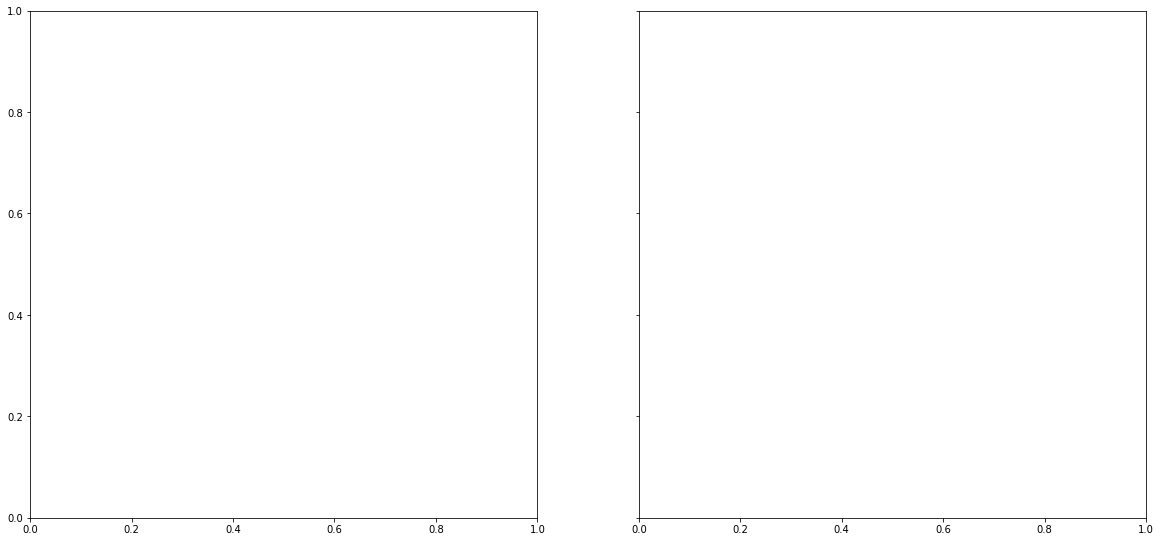

In [18]:
if manual:
    import matplotlib.pyplot as plt

    free.car_los = free.car_los.set_index(['origin', 'destination']).loc[od_set].reset_index()
    fig, axes = plt.subplots(ncols=2, sharey=True, sharex=True, figsize=[20, 20])

    axes[0].set_aspect('equal')
    axes[1].set_aspect('equal')

    from syspy.syspy_utils import data_visualization as dv
    bandwidth = dv.bandwidth
    power=0.5
    lv = [100, 1000, 2000, 5000, 7000]

    url = 'http://a.basemaps.cartocdn.com/dark_nolabels/tileZ/tileX/tileY.png'
    plot = bandwidth(
        free.road_links.loc[free.road_links['flow'] > 0], value_column='flow',
        power=0.5, figsize=[25, 15], scale=0.5, legend_values=lv, 
        label_kwargs={'color':'white', 'fontsize':16}, ax=axes[0]
    )
    dv.add_basemap(plot, url=url, zoom=12)
    plot.set_title("Free assignment")

    plot = bandwidth(
        constrained.road_links.loc[constrained.road_links['flow'] > 0], value_column='flow',
        power=0.5, figsize=[25, 15], scale=0.5, legend_values=lv, 
        label_kwargs={'color':'white', 'fontsize':16}, ax=axes[1]
    )
    dv.add_basemap(plot, url=url, zoom=12)
    plot.set_title("Constrained assignment")
    fig.tigh_layout=True

In [ ]:
if manual:
    c = constrained.car_los.groupby(['origin', 'destination'])['actual_time'].min()
    f = free.car_los.groupby(['origin', 'destination'])['actual_time'].min()
    df = pd.DataFrame([c, f], index=['constrained', 'free']).T
    df.plot(kind='scatter', y='constrained', x='free', figsize=[10, 10], s=1)